# Guannan Shen BIOS 7718 Bio Image  HW1 

In [43]:
# loading required packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
# install open cv 
# anaconda show menpo/opencv3
# conda install --channel https://conda.anaconda.org/menpo opencv3
import cv2 
# odr regression 
from scipy.odr import Model, Data, ODR
from sklearn import linear_model
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0)

# current work
import os
os.getcwd()

'/home/guanshim/Documents/image_data/bio_image'

## References
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html  

https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.identity.html  

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

https://lectures.quantecon.org/py/ols.html

http://blog.rtwilson.com/orthogonal-distance-regression-in-python/

https://docs.scipy.org/doc/scipy/reference/odr.html

http://mathworld.wolfram.com/LeastSquaresFittingPerpendicularOffsets.html

https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy

## Question 1  
We want to fit a line by minimizing the errors: the sum of squared vertical distances between data points and the line; or we will minimize the sum of squared perpendicular distances between data points and the line

### 1 Data Generation
Using equation, $1+6x^o −y^o = 0$ to generate n = 30 data points, where $x^o_i = 0, 1, ..., 29$. The noise is assumed to be independent and identically distributed (i.i.d.) and it follows a multivariate normal distribution with mean $µ = 0$ and covariance $Σ = 5^2I$ (I is the 2 × 2 identify matrix).


Get the clean data points. 

In [55]:
# variables declaration 
n = 30
N = 100
a = 6
b = 1 
mean = [0,0]
cov = 25*np.identity(2)
mean1 = [50,2]
cov1 = 25*np.identity(2)
# 3 columns DF, clean data
v_o = pd.DataFrame({'Inter' : [0]*n,
                    'x' : range(n),
                   'y' : [a*x + b for x in range(n)]} )
v_o.head(3)

,Inter,x,y
0,0,0,1
1,0,1,7
2,0,2,13


Get the noise data, with np.random.multivariate_normal. Concatenate a list of 100 DataFrame. 

In [56]:
# def log(message=None):
#     if message:
#         print("LOG: {0}".format(message))
#     else:
#         print('None')
# log()

In [57]:
# np.random.seed(7)
# set random seed
def noise_gen(n, N, mean, cov, mean1 = None, cov1 = None):
    """
    Assume make one outlier
    n = 30 which is the sample size
    N = 100 which is the number of simulations
    """
    v = []
    if (mean1 is not None) and (cov1 is not None):
        print("Go Outlier!")
        for i in range(N):
            np.random.seed(i)
            noise = pd.DataFrame(np.random.multivariate_normal(mean, cov, n).round(0),
                        columns=['x', 'y'])
            noise['Inter'] = [1]*n
            v_i = noise + v_o
            v_i.loc[n] = np.append([1], np.random.multivariate_normal(mean1, cov1, 1).round(0))
            v.append(v_i)
    elif (not mean1) and (not cov1):
        for i in range(N):
            np.random.seed(i)
            noise = pd.DataFrame(np.random.multivariate_normal(mean, cov, n).round(0),
                        columns=['x', 'y'])
            noise['Inter'] = [1]*n
            v_i = noise + v_o
            v.append(v_i)
    else:
        print('Provide both or neither!')
    v = pd.concat(v, axis=0)
    return v 
    
# v
v = noise_gen(n, N, mean, cov)
v.head(3)

,Inter,x,y
0,1,9.0,3.0
1,1,6.0,18.0
2,1,11.0,8.0


### Fitting ordinal least squares and orthogonal distance regression


#### OLS
For the ordinary least squares, given $y=X\beta+\epsilon$, this is to find the minima of $(y-X\beta)^2$. 

Apply matrix calculus, this is to let the derivative of (with respect to the $\beta$)
$$(\beta^TX^TX\beta - 2y^TX\beta + yTy)$$
which is $$(2X^TX\beta - 2X^Ty = 0)$$
If $(X^TX)$ is invertible. We have the solution of $\beta$
$$\beta = (X^TX)^{-1}X^Ty$$

In [58]:
# fit the OLS
def myOLS(v, n, N):
    Beta = []
    for i in range(1,(N+1),1):
        X = v.iloc[(n*i - n):(n*i), :2]
        y = v.iloc[(n*i - n):(n*i), 2]
        XT = X.T
        Beta.append(np.linalg.inv(XT.dot(X)).dot(XT).dot(y))
    Beta = pd.DataFrame(Beta, columns = ['b', 'a'])
    return Beta
Beta = myOLS(v,n,N)
Beta.head(3)

,b,a
0,9.337740,5.315847
1,0.493314,5.707222
2,31.916606,4.372427


In [59]:
# get the mean of coefs
Beta.loc[N+1] = [np.round(np.mean(Beta['b']),0) , np.round(np.mean(Beta['a']),0) ]
ybeta = [x*Beta.loc[N+1, 'a'] + Beta.loc[N+1, 'b'] for x in range(n)]

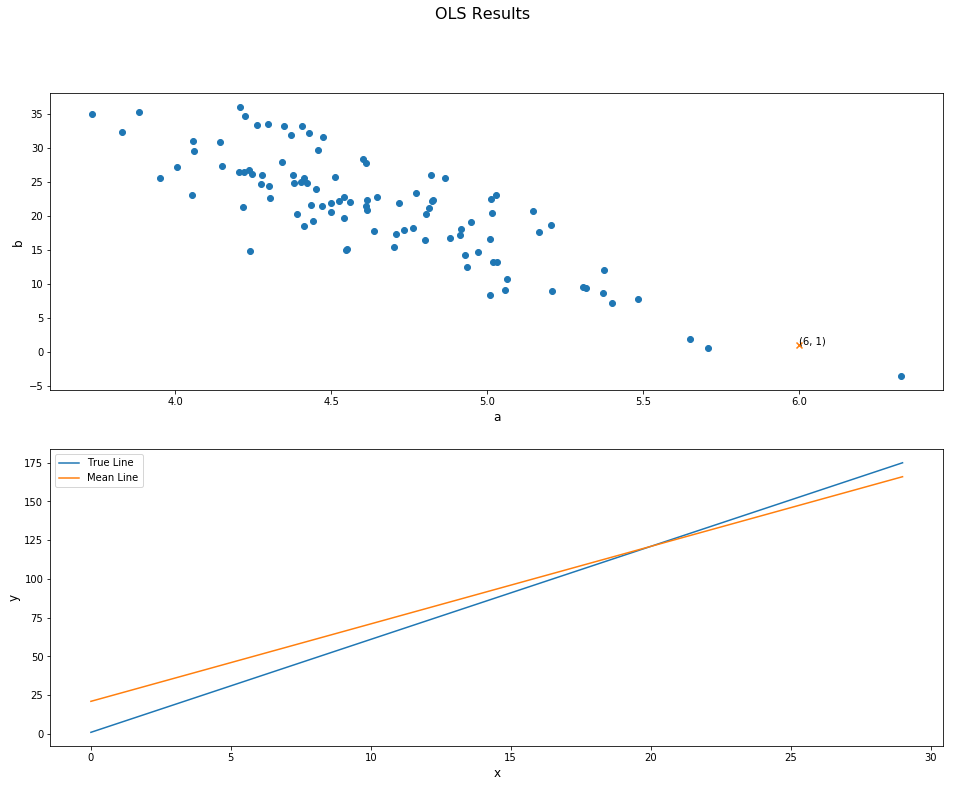

In [60]:
# scatter plot 
# 'OLS Results'
def q1_two_plot(fittingname, Beta, ybeta, a, b): 
    """
    Assume the True beta {'a':6,'b': 1 }
    n = 30 which is the sample size
    N = 100 which is the number of simulations
    """
    fig, ax = plt.subplots(2, 1)
    fig.suptitle(fittingname, fontsize=16)
    # subplot 0
    ax[0].scatter(Beta.loc[:N, 'a'], Beta.loc[:N, 'b'])
    ax[0].scatter(a,b,marker='x')
    ax[0].set_xlabel('a', fontsize=12)
    ax[0].set_ylabel('b', fontsize=12)
    ax[0].annotate((a,b), (a,b))
    # subplot 1
    ax[1].plot(v_o['x'], v_o['y'], label='True Line')
    ax[1].plot(v_o['x'], ybeta, label='Mean Line')
    ax[1].legend()
    ax[1].set_xlabel('x', fontsize=12)
    ax[1].set_ylabel('y', fontsize=12)
    # ?plt.axis()
    plt.show()
    
q1_two_plot('OLS Results', Beta, ybeta, a, b)

#### Orthogonal Distance Regression (ODR)
The benefit of ODR is that this model can take the measurement error into consideration, and it allows that there are errors in both independent and dependent virables. 

Given the linear regression equation $y = ax + b$, the distance between this line and the point $(x_0, y_0)$ is 
$$d_0 = \frac{y_0 - (ax_0 + b)}{\sqrt{(1 + a^2)}}$$
This is to minimize the following equation given n data points:
$$\sum^n_i \frac{[y_i - (ax_i + b)]^2}{(1 + a^2)}$$
This can be solved in closed form (for two-dimensional data).

In this case, the date is two-dimensional, it is called Deming Regression. In this context, the solution can be expressed with the second sample momonts. In other words, the parameters can be calculated by the mean of x and y, the standard deviation of x, y and xy, and the ratio of error variance. [Deming Regression](https://en.wikipedia.org/wiki/Deming_regression).

In general, the total least square problem, [TLS](https://en.wikipedia.org/wiki/Total_least_squares), doesn't have a solution. In the simple case, without assumptions, this can be solved by singular value decomposition. Basically, with error matrices E and F for X and Y respectively:
$$[(X + E)(Y + F)] =  [U_X U_Y]\begin{bmatrix}\Sigma_X & 0\\ 0 & 0\end{bmatrix}\begin{bmatrix}V_{XX}^* & V_{YX}^*\\ V_{XY}^* & V_{YY}^*\end{bmatrix}$$
Using the Eckart-Young theorem, eventually, we can have:
$$B = - V_{XY}V_{YY}^{-1}$$


In [61]:
# the linear model, B[0] = a, B[1] = b
# this function requires initial values
# model
def  f_odr(B, x):
    return B[0]*x + B[1]
linear = Model(f_odr)

def theODR(v, n, N):
    # fitting 
    Beta = []
    for i in range(1,(N+1),1):
        x = v.iloc[(n*i - n):(n*i), 1]
        y = v.iloc[(n*i - n):(n*i), 2]
        data = Data(x, y)
        odr = ODR(data, linear, beta0=[2., 1.])
        odr.output = odr.run()
        Beta.append(odr.output.beta)
    Beta = pd.DataFrame(Beta, columns = ['a', 'b'])
    return(Beta)

Beta = theODR(v,n,N)
Beta.head(3)



,a,b
0,9.389235,-51.219965
1,7.482611,-26.551771
2,5.374543,18.955908


In [62]:
# get the mean of coefs
Beta.loc[N+1] = [np.round(np.mean(Beta['a']),0) , np.round(np.mean(Beta['b']),0) ]
ybeta = [x*Beta.loc[N+1, 'a'] + Beta.loc[N+1, 'b'] for x in range(n)]

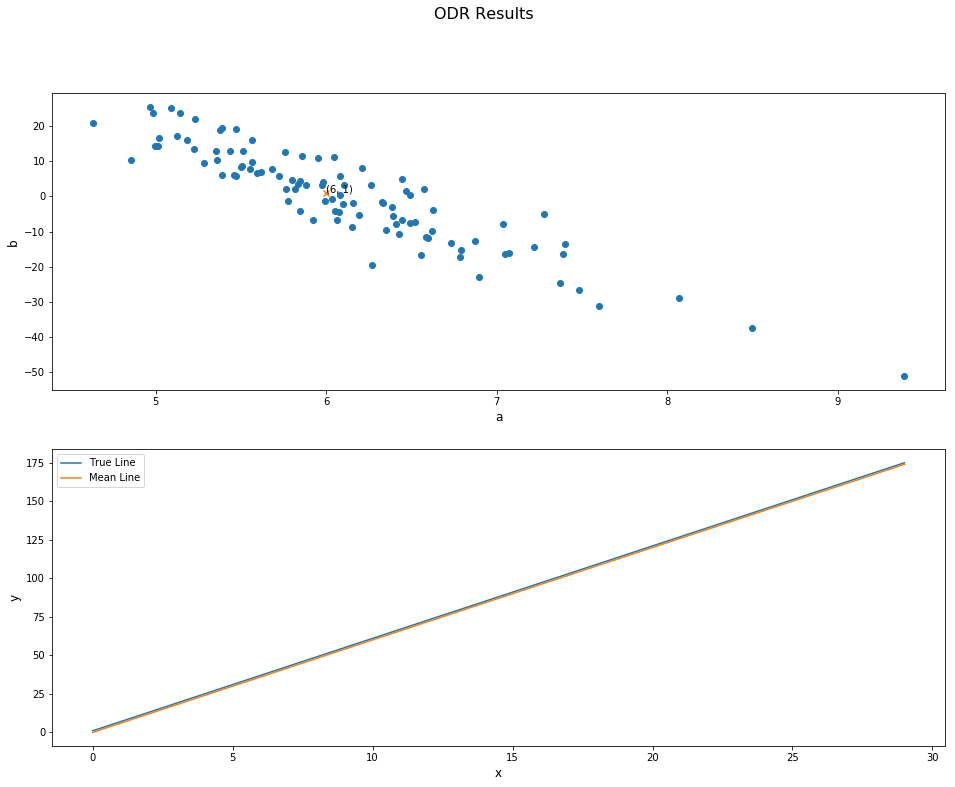

In [63]:
# plot of ODR
q1_two_plot('ODR Results', Beta, ybeta, a, b)

#### Comment
As I mentioned in the ODR session, by minimizing the sum of squared perpendicular distances, the model is more robust to the noise (error) in both x and y, as shown in the line plot of mean a and b, compared with the OLS fitting.

### Fitting with an outlier data

In [64]:
# v
v_out = noise_gen(n, N, mean, cov, mean1, cov1)
v_out.shape

Go Outlier!


(3100, 3)

Fit the OLS with the "outlier data".

In [67]:
Beta = myOLS(v_out,n,N)

# get the mean of coefs
Beta.loc[N+1] = [np.round(np.mean(Beta['b']),0) , np.round(np.mean(Beta['a']),0) ]
ybeta = [x*Beta.loc[N+1, 'a'] + Beta.loc[N+1, 'b'] for x in range(n)]

Beta.head(3)

,b,a
0,9.337740,5.315847
1,37.813330,2.762869
2,46.686935,2.695335


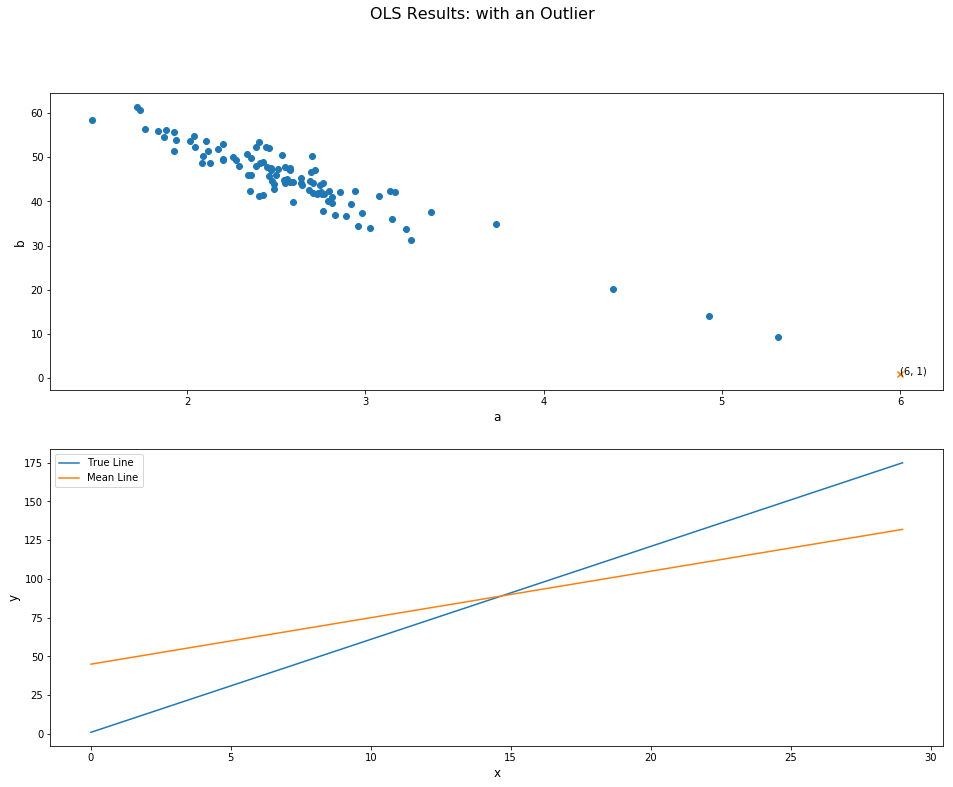

In [68]:
q1_two_plot('OLS Results: with an Outlier', Beta, ybeta, a, b)

Fit the ODR with the "outlier data".

In [74]:
Beta = theODR(v_out,n,N)
# get the mean of coefs
Beta.loc[N+1] = [np.round(np.mean(Beta['a']),0) , np.round(np.mean(Beta['b']),0) ]
ybeta = [x*Beta.loc[N+1, 'a'] + Beta.loc[N+1, 'b'] for x in range(n)]
Beta.head(3)

,a,b
0,9.389235,-51.219965
1,10.832856,-89.692458
2,6.788261,-9.113288


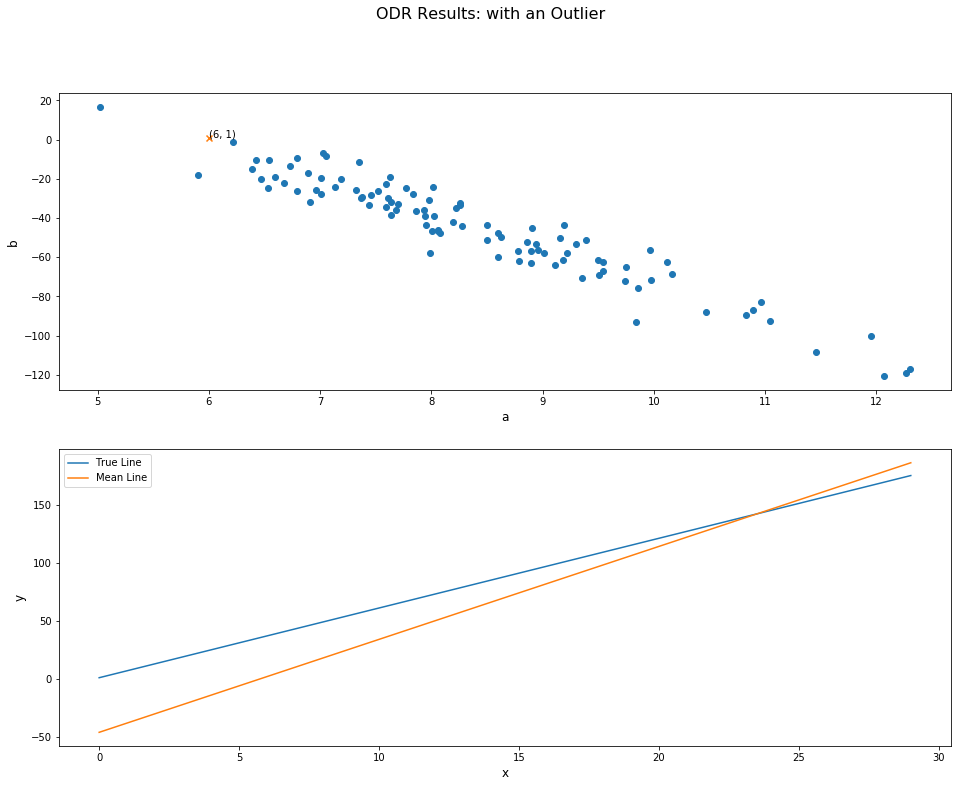

In [75]:
# plot of ODR
q1_two_plot('ODR Results: with an Outlier', Beta, ybeta, a, b)

#### Comment
Compared with the part1, now the dataset contains an outlier. As shown in the above plots, both OLS and ODR fitting were affected a lot by the outlier. Thus, one might choose other framework Which is more robust to the outlier, such as the Random Sample Consensus approach (RANSAC).

## Question 2 
Consider filtering an image (i.e., P2 image.png, given as a separate file) with a Gaussian filter and a median filter.

In [3]:
# read a grayscale 
# , 0 is not required, since the image is already grayscale 
img = cv2.imread('P2_image.png', 0)
# cv2.imshow('p2',img)
print(img.shape)
# 1 second
# cv2.waitKey(1000)
# cv2.destroyAllWindows()

(388, 301)


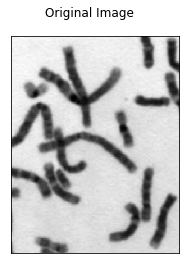

In [39]:
# display image with Matplotlib
# Color image loaded by OpenCV is in BGR mode. But Matplotlib displays in RGB mode. 
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
plt.suptitle('Original Image')
plt.show()

In [10]:
# get the max intensity value 
# min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img)
# print(max_val)

233.0


In [12]:
# np.ones((5,5), np.float32)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

Take note that cv2.filter2D performs correlation, not convolution. However if the kernel is symmetric (that is if you take the transpose and it equals itself), correlation and convolution are equivalent. If this is not the case, you will need to perform a 180 degree rotation of the kernel before using cv2.filter2D. You can do that by simply doing:

kernel = kernel[::-1,::-1]


### Part1

#### Gaussian filter
This filter is based on the bivariate normal distribution, which is:
$$G_{\sigma}(x,y) = \frac{1}{2\pi \sigma^2} \exp{ (-\frac{x^2 + y^2}{2\sigma^2}) }$$
Also the Sum of weights should be 1.

And this is a symmetric kernel and we have the same $\sigma$ for each , thus the calculation of convolution is the same as the correlation. 

Set the Gaussian kernel size as $(6\sigma +1)×(6\sigma +1)$.

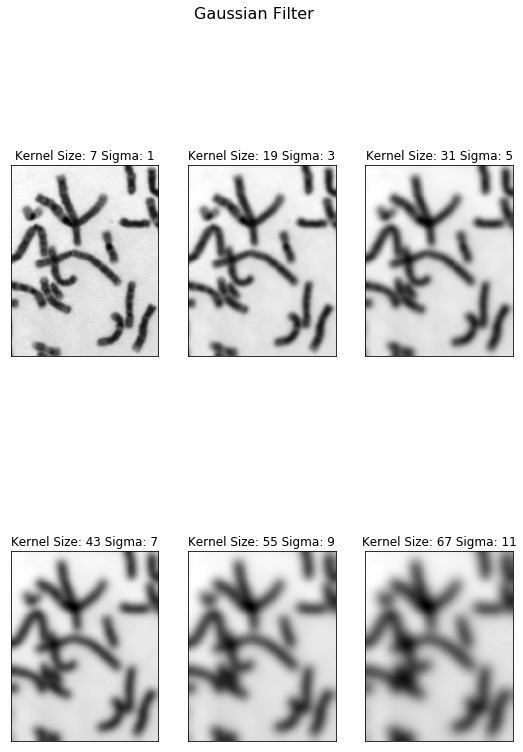

In [58]:
# gaussian filter
# this is discrete for x, y 
fig = plt.figure(figsize=(9, 13))
max_gau_1 = []
ax = []
for i in range(1,13,2):
    size = int(6*i + 1)
    j = int((i-1)/2 + 1)
    sigma = i 
    kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    kernel /= np.sum(kernel)
    gau = cv2.filter2D(img,-1,kernel)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gau)
    max_gau_1.append(max_val)
    fig.suptitle("Gaussian Filter", fontsize=16)
    ax.append(fig.add_subplot(2, 3, j))
    ax[-1].set_title("Kernel Size: " + str(size) + " Sigma: "+ str(i))
    plt.imshow(gau, cmap = 'gray', interpolation='none')
    plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
plt.show()

In [59]:
max_gau_1

[230.0, 226.0, 225.0, 225.0, 224.0, 224.0]

#### Comment
The increment of sigma and kernel size blurs the image. For a small sigma and kernel size such as the first one, the image becomes smoothier. With a big kernel size and sigma such as sigma equals 5 or above, the whole image becomes blurring and lose its contrast. The larger standard deviation is, the pixel value is more affected by its neighbors. 

#### Median filter
This is to replace the intensity value (pixel value) by the median of intensity values in the neighborhood. The neighborhood is defined by the kernel size. The isolated pixels, which are darker or lighter are forced to be more like their neighbors. Thus, if the size of the median filter kernel is too large, the image is blurred heavily. 

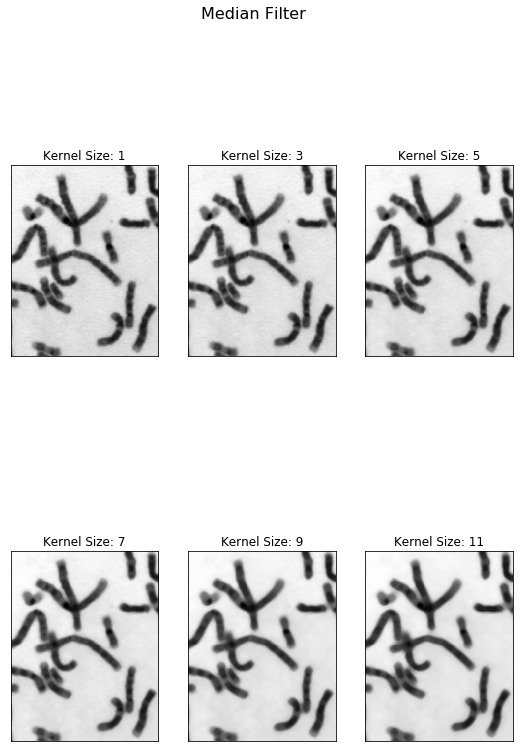

In [60]:
fig = plt.figure(figsize=(9, 13))
ax = []
for i in range(1,13,2):
    j = int((i-1)/2 + 1)
    median = cv2.medianBlur(img,i)
    fig.suptitle("Median Filter", fontsize=16)
    ax.append(fig.add_subplot(2, 3, j))
    ax[-1].set_title("Kernel Size: "+str(i)) 
    plt.imshow(median, cmap = 'gray', interpolation='none')
    plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
plt.show()

#### Comment
Kernel size 1 is the raw image. Compared with the Gaussian

### Gaussian filter large kernel
Set the Gaussian kernel size as $(12\sigma +1)×(12\sigma +1)$.

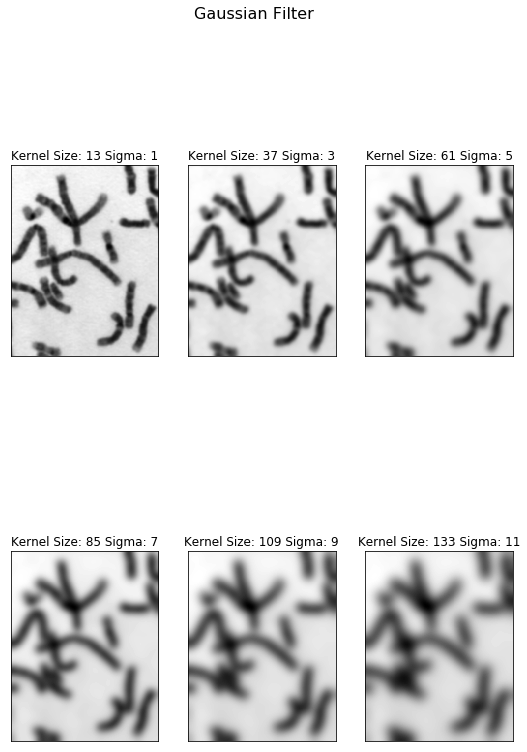

In [67]:
fig = plt.figure(figsize=(9, 13))
max_gau_2 = []
ax = []
for i in range(1,13,2):
    size = int(12*i + 1)
    j = int((i-1)/2 + 1)
    sigma = i 
    kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    kernel /= np.sum(kernel)
    gau = cv2.filter2D(img,-1,kernel)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gau)
    max_gau_2.append(max_val)
    fig.suptitle("Gaussian Filter", fontsize=16)
    ax.append(fig.add_subplot(2, 3, j))
    ax[-1].set_title("Kernel Size: " + str(size) + " Sigma: "+ str(i))
    plt.imshow(gau, cmap = 'gray', interpolation='none')
    plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
plt.show()

In [68]:
# the difference in the max_val
np.array(max_gau_2) - np.array(max_gau_1)

array([0., 0., 0., 0., 0., 0.])

In [46]:
(3,3)

(3, 3)

In [42]:
math.e

NameError: name 'math' is not defined

6

## Question 3
Apply a derivative of Gaussian filter and canny edge detector

### Derivative of Gaussian Filter
Smoothing an image via convolution and then taking derivatives is the same as convolving the image with the derivative of a smoothing kernel.

The Derivative of Gaussian filter on the x direction is:
$$-\frac{x \exp{(-\frac{x^2 + y^2}{2\sigma^2})} }{2\pi\sigma^4}$$
Similarlly, on the y direction:
$$-\frac{y \exp{(-\frac{x^2 + y^2}{2\sigma^2})} }{2\pi\sigma^4}$$

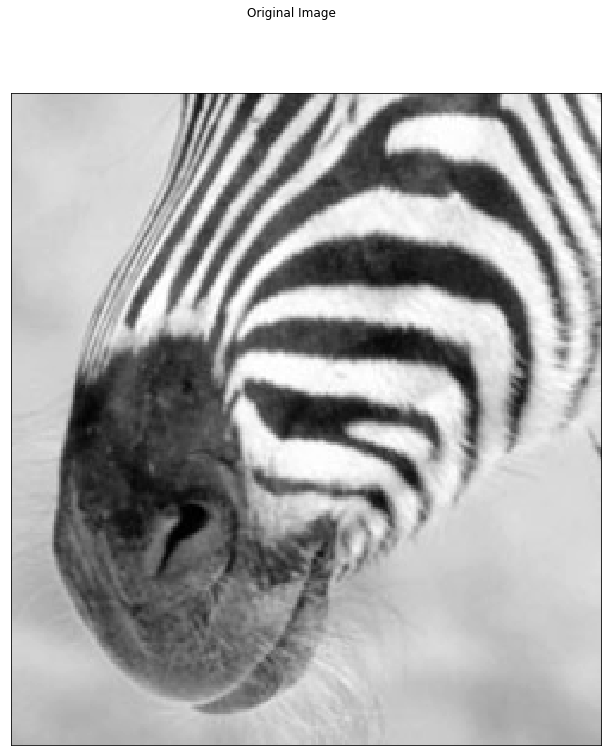

In [69]:
# get the image 
img = cv2.imread('P3_image.png', 0)
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
plt.suptitle('Original Image')
plt.show()